# Training simple model and evalualing its predictions on different tasks

## Prepare dataset for training

First let's load splitted dataset generated in [another notebook](https://github.com/tinyclues/recsys-multi-atrribute-benchmark/blob/master/dataset_preprocessing/movielens%20with%20imdb.ipynb)

In [1]:
import os
import tensorflow as tf

from utils import DATASETS_ROOT_DIR

datasets = {}
for split_name in ['train', 'val', 'test']:
    path = os.path.join(DATASETS_ROOT_DIR, f'movielens_imdb/aggregated_{split_name}_dataset.tf')
    datasets[split_name] = tf.data.experimental.load(path, compression="GZIP")

2023-02-03 15:11:51.639428: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2023-02-03 15:11:51.639483: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-03 15:11:54.084253: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2023-02-03 15:11:54.084307: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN E

We can parse features' names, they were chosen to easily distinguish between offer features (that will be used to modelize film) and user features (aggregated history up to chosen date).

In [2]:
from utils import AGG_PREFIX

all_columns = list(datasets['train'].element_spec.keys())
technical_columns = ['userId', 'date']
user_features = list(filter(lambda x: x.startswith(AGG_PREFIX), all_columns))
offer_features = list(filter(lambda x: x not in user_features + technical_columns, all_columns))

In [3]:
user_features

['aggregated_ratings_startYearCluster',
 'aggregated_ratings_titleType',
 'aggregated_ratings_director',
 'aggregated_ratings_genre',
 'aggregated_ratings_runtimeMinutesCluster',
 'aggregated_ratings_imdbId',
 'aggregated_ratings_actor']

In [4]:
offer_features

['startYearCluster',
 'titleType',
 'imdbId',
 'director',
 'actor',
 'genre',
 'runtimeMinutesCluster']

### Negative sampling

Now the last missing element to start a training is that our dataset contains only positive examples. We have different choices of how to choose negative examples, but for simplicity let's precalculate them inside each batches. Proceding in minibatches:
* let's fix a number `N - 1` of how many negative examples we want to generate for each positive one
* consider minibatches of size `N` with events done on the same (or close) date
* inside each minibatch we have users `u1, u2, ..., uN` who rated films `f1, f2, ..., fN` respectively on the same date `d`
* let's consider all possible pairs `(u1, f1), (u1, f2), ..., (uN, fN)` (`N ** 2` pairs in total)
* among those pairs we can keep only those not present in initial minibatch and keep `~N(N - 1)` negative pairs
* it gives us exactly `N - 1` negative examples for each from `N` positive ones

In [5]:
%%time

from functools import partial
from uuid import uuid4

from utils import merge_dims, generate_negatives_in_minibatches_and_rebatch

for key in ['val', 'test']:
    datasets[key] = generate_negatives_in_minibatches_and_rebatch(
        datasets[key].map(partial(merge_dims, 0, 1)),
        batch_size=63000, number_of_negatives=4, offer_features=offer_features,
        user_id_column='userId', date_column='date',
        deterministic=True, seed=1729).cache(f'/tmp/{uuid4()}.tf')
datasets['train'] = generate_negatives_in_minibatches_and_rebatch(
    datasets['train'].map(partial(merge_dims, 0, 1)),
    batch_size=17500, number_of_negatives=4, offer_features=offer_features,
    user_id_column='userId', date_column='date',
    deterministic=False)

CPU times: user 54.9 s, sys: 8.52 s, total: 1min 3s
Wall time: 1min 3s


At the same time with generation of negatives we will unnest events for each user (stored in second dimension of saved tensors) and rebatch big batches into smaller ones (`63000` events for validation and test sets and `17500` events for train set).

In [6]:
train_batch, y = next(iter(datasets['train']))
train_batch['imdbId'].shape[0]  # check batch size

17500

## Define simple model

Let's now define a simple model we want to test. Independetly from model's choice we need to embed inputs in some vectorial space. To define such embeddings we need number of different modalities inputs can take, and we can get this information from saved vectorizers:

In [7]:
from utils import load_inverse_lookups
inverse_lookups = load_inverse_lookups(os.path.join(DATASETS_ROOT_DIR, 'movielens_imdb/inverse_lookups.pickle'))

In [8]:
import re

vocabulary_sizes = {}

for feature in offer_features:
    vocabulary_sizes[feature] = inverse_lookups[feature].vocabulary_size()

for feature in user_features:
    for key in inverse_lookups:
        pattern = re.compile(r"{}(\w+)_{}".format(AGG_PREFIX, key))
        if pattern.match(feature):
            vocabulary_sizes[feature] = vocabulary_sizes[key]

Now `vocabulary_sizes` contains modality of each feature

In [9]:
vocabulary_sizes

{'startYearCluster': 40,
 'titleType': 20,
 'imdbId': 7894,
 'director': 3104,
 'actor': 2507,
 'genre': 36,
 'runtimeMinutesCluster': 35,
 'aggregated_ratings_startYearCluster': 40,
 'aggregated_ratings_titleType': 20,
 'aggregated_ratings_director': 3104,
 'aggregated_ratings_genre': 36,
 'aggregated_ratings_runtimeMinutesCluster': 35,
 'aggregated_ratings_imdbId': 7894,
 'aggregated_ratings_actor': 2507}

### Model architecture

For the benchmarks we want to do, model's architecture doesn't play a crucial role, we saw the same problems in any model that averages embeddings of offer features in a naive way. So let's take some simple model's architecture, for example collaborative filtering using two towers neural network:

<img src="resources/two_towers_model.png" alt="two tower model" width="800" />

### Model parameters

To choose model's parameters we did some manual tuning using validation set to maximize train and test AUC while keeping mismatch between them small.

In [39]:
# model parameters
EMBEDDING_DIM = 50
L1_COEFF = 1e-8
DROPOUT = 0.05

# TODO remove ?
# def INITIALIZER():
#     return {'class_name': 'RandomNormal', 'config': {'stddev': 0.1}}

def REGULARIZER():
    return {'class_name': 'L1L2', 'config': {'l1': L1_COEFF, 'l2': 0.}}

def USER_TOWER():
    return tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(70,
                              kernel_regularizer=REGULARIZER(),
                              bias_regularizer=REGULARIZER()),
        tf.keras.layers.Dropout(DROPOUT),
        tf.keras.layers.Activation('ReLU'),
    ], name='user_tower')

def OFFER_TOWER():
    return tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(70,
                              kernel_regularizer=REGULARIZER(),
                              bias_regularizer=REGULARIZER()),
        tf.keras.layers.Dropout(DROPOUT),
        tf.keras.layers.Activation('ReLU'),
    ], name='offer_tower')

EPOCHS = 3

LOSS = tf.keras.losses.BinaryCrossentropy(from_logits=True)
AUC_METRIC = tf.keras.metrics.AUC(from_logits=True)

import tensorflow_addons as tfa
OPTIMIZER = tfa.optimizers.AdamW(weight_decay=1e-8, learning_rate=0.002)

### Embeddings

Let's embed all available `user_features` and `offer_features` into vectorial space of dimension `EMBEDDING_DIM`. We use custom embeddings layer class `WeightedEmbeddings` that will automatically take a mean embedding vector when needed.

In particular,
* `user_features` are lists of attributes and we don't need to take into account any weights.
* `offer_features` during the inference can contain lists of attributes because of aggregation. We will also pass weights explicitly during the inference
* `offer_features` during training are lists with only one element, so we need to define dummy weights for training (it is done in `generate_negatives_in_minibatches_and_rebatch`)

All three cases can be treated by the same layer, where we will define a sparse matrix of all attributes we want to embed and then multiply it by the dense matrix with embeddings, multiplying by weights at the same time (if needed).

In [12]:
# dummy weights needed for training
train_batch['genre_weight'][:5]

<tf.RaggedTensor [[1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0]]>

In [13]:
# embeddings layer example
from layers import WeightedEmbeddings
example_layer = WeightedEmbeddings(3, 5, name='test')
example_layer(tf.ragged.constant([[0], [1], [0, 1]]))

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[ 0.01725112, -0.03246962,  0.03851921,  0.02020098,  0.03175594],
       [-0.04253745, -0.04916964,  0.04609753,  0.00103287,  0.0437494 ],
       [-0.01264316, -0.04081963,  0.04230837,  0.01061692,  0.03775267]],
      dtype=float32)>

Now we can define all embeddings layers:

In [40]:
from layers import get_input_layer
from utils import WEIGHT_SUFFIX

embeddings, inputs = {}, {}
for feature in user_features + offer_features:
    if feature in offer_features:
        # for offer features we need weights:
        # with dummy weights during training, and the ones used for a feature's averaging at inference time
        inputs[f'{feature}_weight'] = get_input_layer(f'{feature}_weight', tf.float32)
    inputs[feature] = get_input_layer(feature)
    # here we use input feature modality from `vocabulary_sizes` to know embeddings matrix dimensions
    emb_layer = WeightedEmbeddings(vocabulary_sizes[feature],
                                   EMBEDDING_DIM, name=f'{feature}_embedding',
                                   # embeddings_initializer=INITIALIZER(),
                                   embeddings_regularizer=REGULARIZER())
    embeddings[feature] = emb_layer(inputs[feature], inputs.get(f'{feature}_weight'))

In [41]:
embeddings

{'aggregated_ratings_startYearCluster': <KerasTensor: shape=(None, 50) dtype=float32 (created by layer 'aggregated_ratings_startYearCluster_embedding')>,
 'aggregated_ratings_titleType': <KerasTensor: shape=(None, 50) dtype=float32 (created by layer 'aggregated_ratings_titleType_embedding')>,
 'aggregated_ratings_director': <KerasTensor: shape=(None, 50) dtype=float32 (created by layer 'aggregated_ratings_director_embedding')>,
 'aggregated_ratings_genre': <KerasTensor: shape=(None, 50) dtype=float32 (created by layer 'aggregated_ratings_genre_embedding')>,
 'aggregated_ratings_runtimeMinutesCluster': <KerasTensor: shape=(None, 50) dtype=float32 (created by layer 'aggregated_ratings_runtimeMinutesCluster_embedding')>,
 'aggregated_ratings_imdbId': <KerasTensor: shape=(None, 50) dtype=float32 (created by layer 'aggregated_ratings_imdbId_embedding')>,
 'aggregated_ratings_actor': <KerasTensor: shape=(None, 50) dtype=float32 (created by layer 'aggregated_ratings_actor_embedding')>,
 'star

### Combining everything into model

Now we can define described model architecture on the top of embeddings.

In [42]:
embedded_user_features = [embeddings[feature] for feature in user_features]
embedded_offer_features = [embeddings[feature] for feature in offer_features]
user_tower = USER_TOWER()(tf.keras.layers.Concatenate(name='concat_user')(embedded_user_features))
offer_tower = OFFER_TOWER()(tf.keras.layers.Concatenate(name='concat_offer')(embedded_offer_features))
# we don't apply sigmoid on the output and will have from_logits=True in both loss and metrics
output = tf.keras.layers.Dense(1, name='prediction')(
    tf.keras.layers.Multiply(name='interaction')([user_tower, offer_tower])
)

In [43]:
output

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'prediction')>

In [44]:
model = tf.keras.Model(inputs, output, name='two_tower_model')
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[AUC_METRIC])

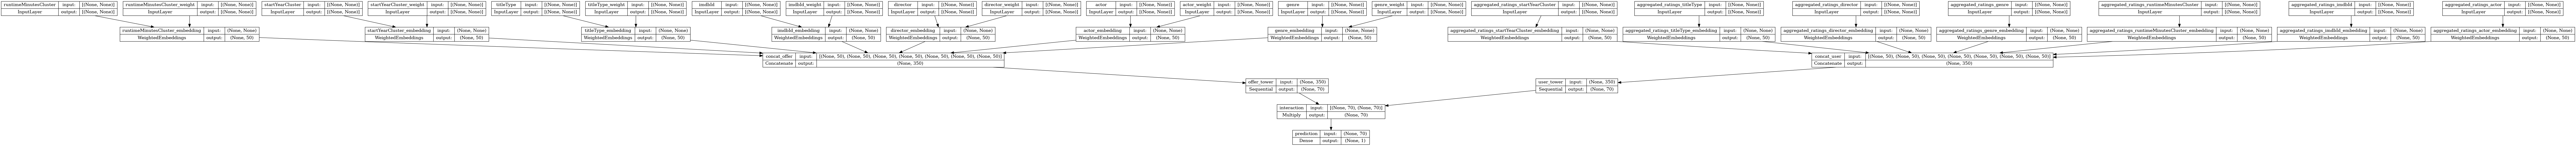

In [45]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='models/simple_model.png')

### Training

In [46]:
model.fit(datasets['train'], epochs=EPOCHS, validation_data=datasets['val'])

Epoch 1/3


/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['userId', 'date'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


2428/2428 [==============================] - 843s 334ms/step - loss: 0.4800 - auc_2: 0.6236 - val_loss: 0.4824 - val_auc_2: 0.6242
Epoch 2/3
2428/2428 [==============================] - 801s 327ms/step - loss: 0.4736 - auc_2: 0.6421 - val_loss: 0.4830 - val_auc_2: 0.6262
Epoch 3/3
2428/2428 [==============================] - 778s 318ms/step - loss: 0.4720 - auc_2: 0.6467 - val_loss: 0.4831 - val_auc_2: 0.6274


## Baseline model (In progress)

In [ ]:
LOSS = tf.keras.losses.BinaryCrossentropy(from_logits=True)
OPTIMIZER = tfa.optimizers.AdamW(weight_decay=5e-6, learning_rate=0.002)

In [ ]:
embeddings, inputs = {}, {}
for feature in user_features + [OFFER_FEATURE_TO_SCORE]:
    if feature == OFFER_FEATURE_TO_SCORE:
        inputs[f'{feature}_weight'] = get_input_layer(f'{feature}_weight', tf.float32)
    inputs[feature] = get_input_layer(feature)
    
    emb_layer = WeightedEmbeddings(vocabulary_sizes[feature],
                                   EMBEDDING_DIM, name=f'{feature}_embedding',
                                   embeddings_initializer=INITIALIZER(),
                                   embeddings_regularizer=REGULARIZER())
    embeddings[feature] = emb_layer(inputs[feature], inputs.get(f'{feature}_weight'))

In [ ]:
user_emb = tf.keras.layers.Concatenate(name='concat_user')([embeddings[feature] for feature in user_features])
offer_emb = embeddings[OFFER_FEATURE_TO_SCORE]
user_tower = USER_TOWER()(user_emb)
offer_tower = OFFER_TOWER()(offer_emb)
output = tf.keras.layers.Dense(1, name='prediction')(
    tf.keras.layers.Multiply(name='interaction')([user_tower, offer_tower])
)

In [ ]:
baseline_model = tf.keras.Model(inputs, output, name='two_tower_model_baseline')
baseline_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[AUC_METRIC])

In [ ]:
baseline_model.fit(datasets['train'], epochs=EPOCHS, validation_data=datasets['val'])

In [ ]:
%%time
baseline_scores = evaluate_model(baseline_model, test_ds, inverse_lookups, OFFER_FEATURE_TO_SCORE)

In [ ]:
baseline_scores

In [ ]:
pd.merge(baseline_scores[['auc']], scores, left_index=True, right_index=True,
         suffixes=('_baseline', ''))